In [3]:
import random
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython.display import display
from torch.utils.data import Dataset, DataLoader

In [4]:
random.seed(69)
np.random.seed(69)
torch.manual_seed(69)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(69)

device = torch.device("cpu")

In [5]:
from torchvision.transforms import Resize, InterpolationMode

resizer = Resize((256, 256), interpolation=InterpolationMode.NEAREST_EXACT)

In [6]:
gbc_ndarray = np.load("gbc_dataset.npy")

class GBCDataset(Dataset):
    """
    Implement gameboy character dataset (GBCDataset) class.

    Attributes:
        dat (np.ndarray): Data.
        dev (str): Device.
    """
    def __init__(self, data, device):
        """
        Instantiate GBCDataset class.

        Args:
            data (np.ndarray): Data.
            device (str): Device.
        """
        self.dat = data
        self.dev = device

    def __len__(self):
        """
        Get dataset cardinality.

        Returns:
            int: Dataset cardinality.
        """
        return self.dat.shape[0]

    def __getitem__(self, index):
        """
        Get dataset element.

        Args:
            index (int): Index.

        Returns:
            torch.Tensor: Dataset element.
        """
        return torch.from_numpy(self.dat[index].astype(np.float32) / 127.5 - 1.0).to(self.dev)

gbc_dataset = GBCDataset(gbc_ndarray, device)
gbc_data_loader = DataLoader(gbc_dataset, 26, True)

In [7]:
from torchvision.transforms import Resize, InterpolationMode
from tqdm import tqdm

resizer = Resize((256, 256), interpolation=InterpolationMode.NEAREST_EXACT)

class GBCGAN:
    def __init__(self, device: str = "cuda") -> None:
        """
        Instantiate GBCGAN class.
        
        Args:
            device (str): Device.
        """
        self.dev = device
        self._dis_net, self._dis_opt = self._get_discriminator()
        self._gen_net, self._gen_opt = self._get_generator()
        self._lat_dim = self._gen_net[0].in_channels
        self._los_fun = nn.BCELoss()

    def _get_discriminator(self) -> Tuple[nn.Sequential, optim.Optimizer]:
        network = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(self.dev)

        optimiser = optim.Adam(network.parameters(), lr=0.0002, betas=(0.5, 0.999))

        return network, optimiser

    def _get_generator(self) -> Tuple[nn.Sequential, optim.Optimizer]:
        network = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(self.dev)

        optimiser = optim.Adam(network.parameters(), lr=0.0002, betas=(0.5, 0.999))

        return network, optimiser

    def generate_images(self, batch_size):
        random_latents = torch.randn(batch_size, self._lat_dim, 1, 1, device=self.dev)
        temp_images = self._gen_net(random_latents)
        fake_images = Image.new("L", (16 * batch_size, 16))

        for i in range(batch_size):
            fake_images.paste(Image.fromarray(np.squeeze((127.5 * (temp_images[i].cpu().detach().numpy().transpose(1, 2, 0) + 1.0)).astype(np.uint8))), (16 * i, 0))

        return fake_images


    def train(self, gbc_data_loader: DataLoader, epoch_number: int=1) -> None:
        """
        Train discriminator network and generator network.

        Args:
            gbc_data_loader (DataLoader): GBC data loader.
            epoch_number (int): Epochs number.
        """
        self._dis_net.train()
        self._gen_net.train()

        for epoch in range(epoch_number):
            discriminator_losses = []
            generator_losses = []

            for real_images in tqdm(gbc_data_loader):
                
                # Train discriminator

                random_latents = torch.randn(real_images.size(0), self._lat_dim, 1, 1, device=self.dev)
                fake_images = self._gen_net(random_latents)
                fake_probs = self._dis_net(fake_images)
                fake_labels = torch.zeros_like(fake_probs)

                real_probs = self._dis_net(real_images)
                real_labels = torch.ones_like(real_probs)

                discriminator_loss = self._los_fun(fake_probs, fake_labels) + self._los_fun(real_probs, real_labels)
                self._dis_opt.zero_grad()
                discriminator_loss.backward()
                self._dis_opt.step()

                discriminator_losses.append(discriminator_loss.item())
                
                # Train generator

                random_latents = torch.randn(real_images.size(0), self._lat_dim, 1, 1, device=self.dev)
                fake_images =  self._gen_net(random_latents)
                fake_probs = self._dis_net(fake_images)
                real_labels = torch.ones_like(fake_probs)

                generator_loss = self._los_fun(fake_probs, real_labels)
                self._gen_opt.zero_grad()
                generator_loss.backward()
                self._gen_opt.step()

                generator_losses.append(generator_loss.item())

            print(f"Epoch: [{epoch + 1}/{epoch_number}]")
            print(f"Discriminator loss: {np.mean(discriminator_losses):.4f}")
            print(f"Generator loss: {np.mean(generator_losses):.4f}")
            image = self.generate_images(1)
            image_resized = resizer(image)
            display(image_resized)
            image_resized.save(f"images/epoch{epoch+1}.png")

        self._dis_net.eval()
        self._gen_net.eval()
gbc_gan = GBCGAN(device)

100%|██████████| 7134/7134 [01:31<00:00, 77.71it/s]

Epoch: [1/40]
Discriminator loss: 0.1041
Generator loss: 4.6502


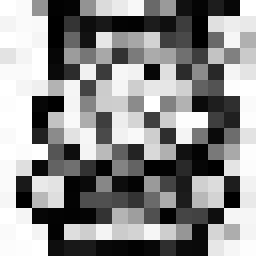

100%|██████████| 7134/7134 [01:27<00:00, 81.15it/s]

Epoch: [2/40]
Discriminator loss: 0.0217
Generator loss: 7.0487


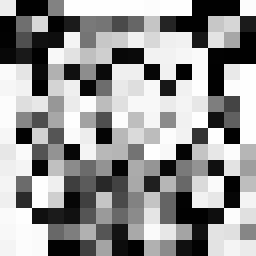

100%|██████████| 7134/7134 [01:27<00:00, 81.50it/s]

Epoch: [3/40]
Discriminator loss: 0.0184
Generator loss: 7.9888


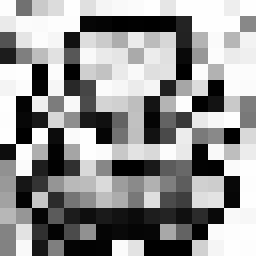

100%|██████████| 7134/7134 [01:27<00:00, 81.59it/s]

Epoch: [4/40]
Discriminator loss: 0.0150
Generator loss: 8.5200


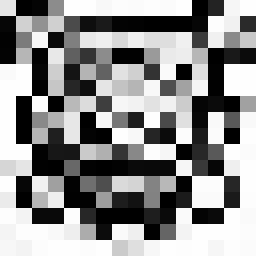

100%|██████████| 7134/7134 [01:25<00:00, 83.01it/s]

Epoch: [5/40]
Discriminator loss: 0.0179
Generator loss: 8.7116


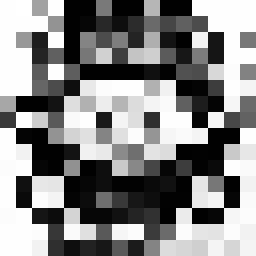

100%|██████████| 7134/7134 [01:28<00:00, 80.31it/s]

Epoch: [6/40]
Discriminator loss: 0.0115
Generator loss: 9.2363


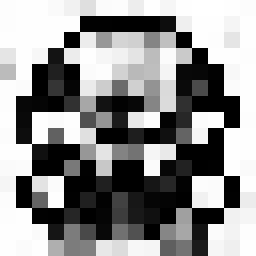

100%|██████████| 7134/7134 [01:27<00:00, 81.54it/s]

Epoch: [7/40]
Discriminator loss: 0.0141
Generator loss: 9.4204


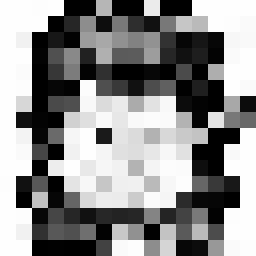

100%|██████████| 7134/7134 [01:29<00:00, 79.50it/s]

Epoch: [8/40]
Discriminator loss: 0.0114
Generator loss: 9.7690


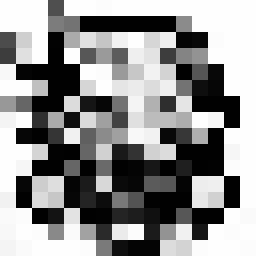

100%|██████████| 7134/7134 [01:27<00:00, 81.66it/s]

Epoch: [9/40]
Discriminator loss: 0.0125
Generator loss: 9.9154


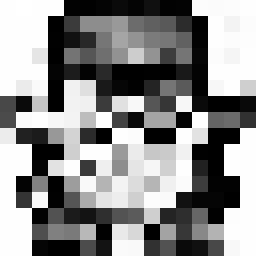

100%|██████████| 7134/7134 [01:28<00:00, 80.65it/s]

Epoch: [10/40]
Discriminator loss: 0.0112
Generator loss: 10.2916


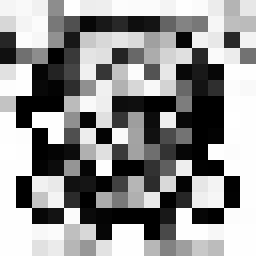

100%|██████████| 7134/7134 [01:27<00:00, 81.24it/s]

Epoch: [11/40]
Discriminator loss: 0.0124
Generator loss: 10.2156


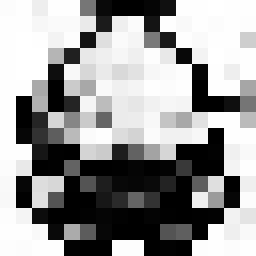

100%|██████████| 7134/7134 [01:23<00:00, 85.39it/s]

Epoch: [12/40]
Discriminator loss: 0.0105
Generator loss: 10.5013


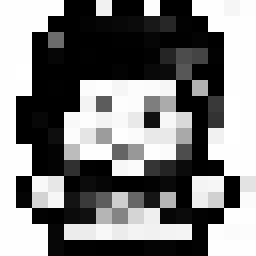

100%|██████████| 7134/7134 [01:18<00:00, 90.70it/s]

Epoch: [13/40]
Discriminator loss: 0.0100
Generator loss: 10.5812


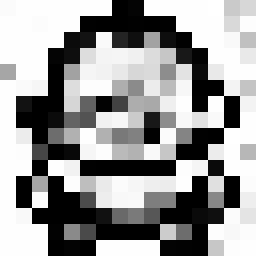

100%|██████████| 7134/7134 [01:18<00:00, 91.12it/s]

Epoch: [14/40]
Discriminator loss: 0.0095
Generator loss: 10.8227


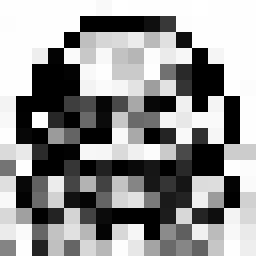

100%|██████████| 7134/7134 [01:18<00:00, 90.75it/s]

Epoch: [15/40]
Discriminator loss: 0.0072
Generator loss: 10.9581


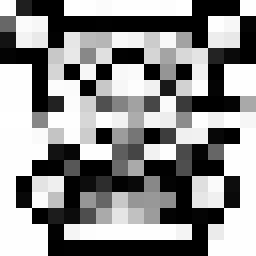

100%|██████████| 7134/7134 [01:20<00:00, 88.15it/s]

Epoch: [16/40]
Discriminator loss: 0.0103
Generator loss: 10.9288


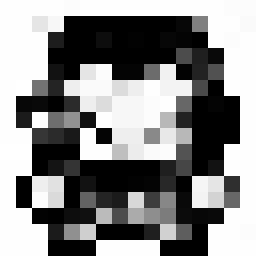

100%|██████████| 7134/7134 [01:24<00:00, 84.39it/s]

Epoch: [17/40]
Discriminator loss: 0.0100
Generator loss: 11.0639


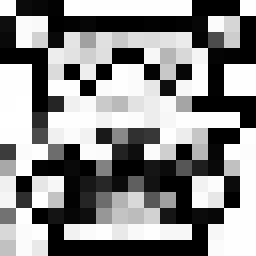

100%|██████████| 7134/7134 [01:21<00:00, 87.60it/s]

Epoch: [18/40]
Discriminator loss: 0.0081
Generator loss: 11.2549


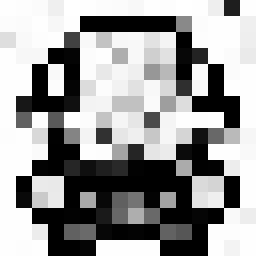

100%|██████████| 7134/7134 [01:18<00:00, 91.35it/s]

Epoch: [19/40]
Discriminator loss: 0.0077
Generator loss: 11.4025


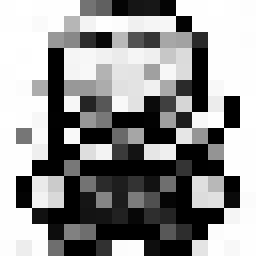

100%|██████████| 7134/7134 [01:19<00:00, 90.21it/s]

Epoch: [20/40]
Discriminator loss: 0.0093
Generator loss: 11.2760


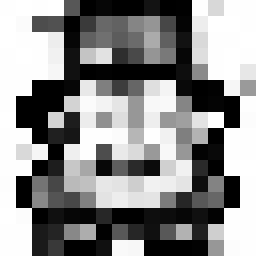

100%|██████████| 7134/7134 [01:20<00:00, 88.99it/s]

Epoch: [21/40]
Discriminator loss: 0.0081
Generator loss: 11.5188


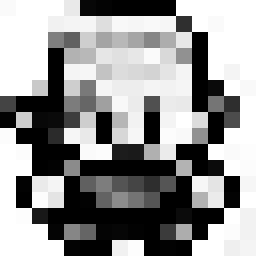

100%|██████████| 7134/7134 [01:18<00:00, 90.81it/s]

Epoch: [22/40]
Discriminator loss: 0.0065
Generator loss: 11.7845


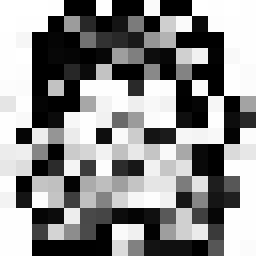

100%|██████████| 7134/7134 [01:20<00:00, 88.47it/s]

Epoch: [23/40]
Discriminator loss: 0.0073
Generator loss: 11.7403


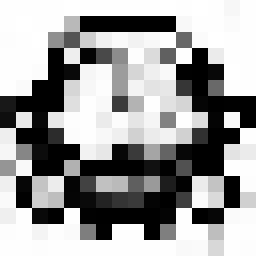

100%|██████████| 7134/7134 [01:20<00:00, 88.64it/s]

Epoch: [24/40]
Discriminator loss: 0.0091
Generator loss: 11.6658


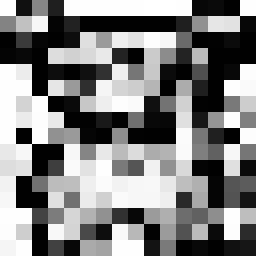

100%|██████████| 7134/7134 [01:20<00:00, 88.96it/s]

Epoch: [25/40]
Discriminator loss: 0.0070
Generator loss: 12.0421


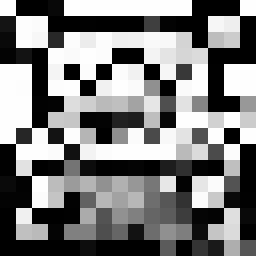

100%|██████████| 7134/7134 [01:19<00:00, 89.90it/s]

Epoch: [26/40]
Discriminator loss: 0.0069
Generator loss: 11.9635


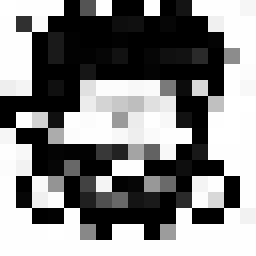

100%|██████████| 7134/7134 [01:19<00:00, 89.80it/s]

Epoch: [27/40]
Discriminator loss: 0.0081
Generator loss: 12.1117


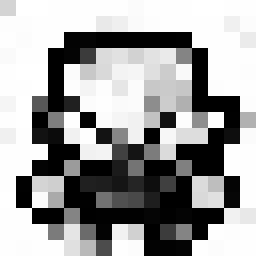

100%|██████████| 7134/7134 [01:20<00:00, 88.99it/s]

Epoch: [28/40]
Discriminator loss: 0.0066
Generator loss: 12.1791


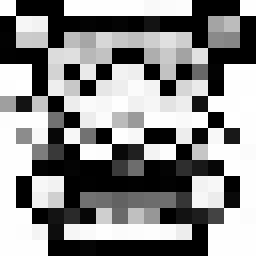

100%|██████████| 7134/7134 [01:17<00:00, 91.80it/s]

Epoch: [29/40]
Discriminator loss: 0.0060
Generator loss: 12.4197


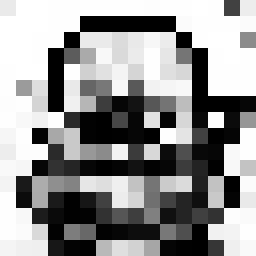

100%|██████████| 7134/7134 [01:18<00:00, 90.56it/s]

Epoch: [30/40]
Discriminator loss: 0.0061
Generator loss: 12.6237


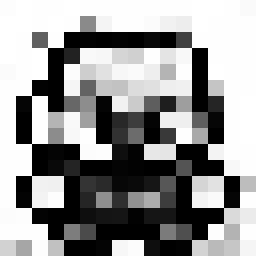

100%|██████████| 7134/7134 [01:19<00:00, 89.94it/s]

Epoch: [31/40]
Discriminator loss: 0.0062
Generator loss: 12.2875


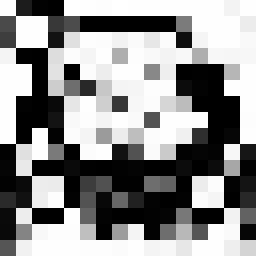

100%|██████████| 7134/7134 [01:19<00:00, 90.11it/s]

Epoch: [32/40]
Discriminator loss: 0.0059
Generator loss: 12.6293


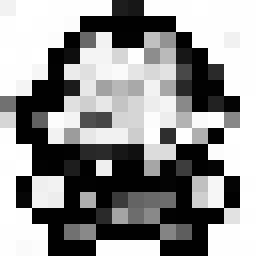

100%|██████████| 7134/7134 [01:19<00:00, 89.36it/s]

Epoch: [33/40]
Discriminator loss: 0.0064
Generator loss: 12.6478


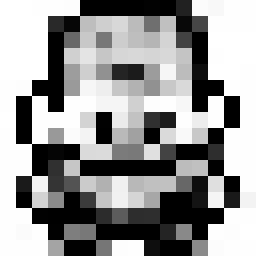

100%|██████████| 7134/7134 [01:20<00:00, 89.11it/s]

Epoch: [34/40]
Discriminator loss: 0.0066
Generator loss: 12.6209


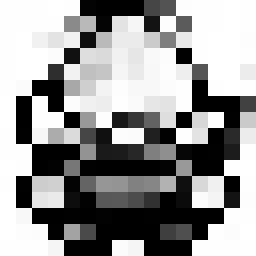

100%|██████████| 7134/7134 [01:21<00:00, 87.76it/s]

Epoch: [35/40]
Discriminator loss: 0.0063
Generator loss: 12.4977


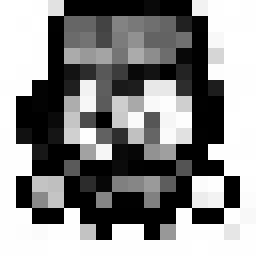

100%|██████████| 7134/7134 [01:18<00:00, 90.88it/s]

Epoch: [36/40]
Discriminator loss: 0.0052
Generator loss: 12.9814


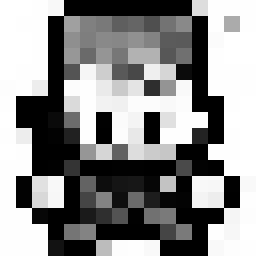

100%|██████████| 7134/7134 [01:17<00:00, 91.57it/s]

Epoch: [37/40]
Discriminator loss: 0.0070
Generator loss: 12.8503


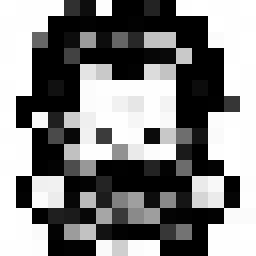

100%|██████████| 7134/7134 [01:19<00:00, 90.26it/s]

Epoch: [38/40]
Discriminator loss: 0.0047
Generator loss: 12.9642


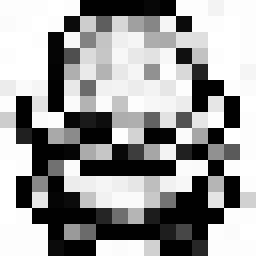

100%|██████████| 7134/7134 [01:18<00:00, 90.72it/s]

Epoch: [39/40]
Discriminator loss: 0.0050
Generator loss: 12.8905


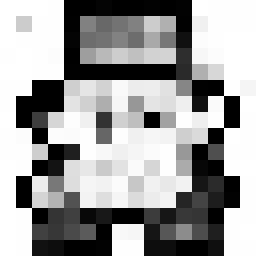

100%|██████████| 7134/7134 [01:20<00:00, 88.80it/s]

Epoch: [40/40]
Discriminator loss: 0.0057
Generator loss: 12.8500


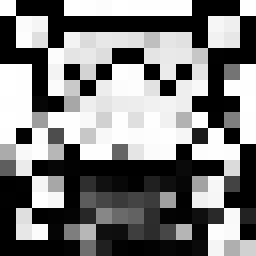

In [8]:
gbc_gan.train(gbc_data_loader, 40)

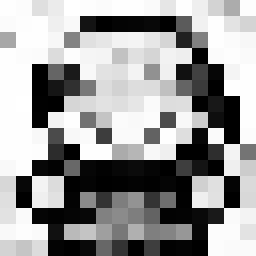

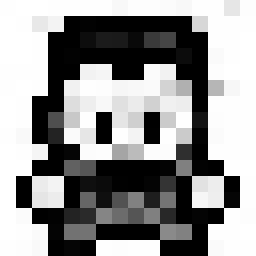

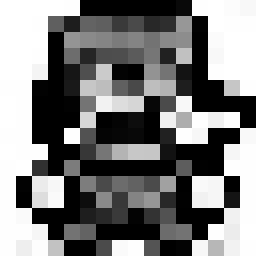

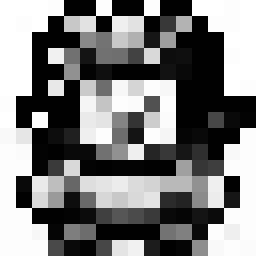

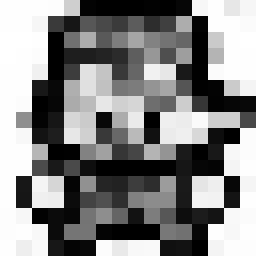

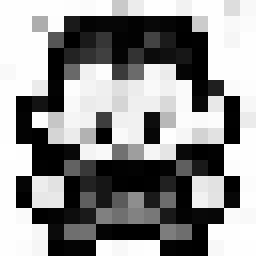

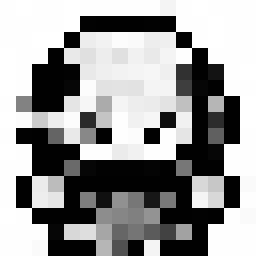

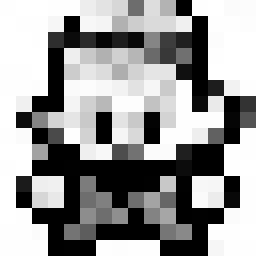

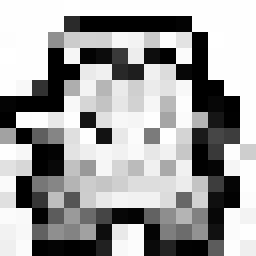

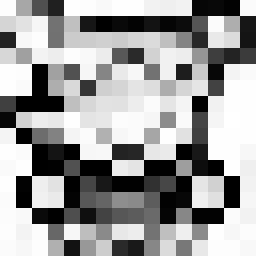

In [11]:
for i in range(10):
    fake_images = gbc_gan.generate_images(1)
    images = resizer(fake_images)
    display(images)
    images.save(f"after-training/{i+1}.png")

In [10]:
torch.save(gbc_gan._dis_net.state_dict(), "discriminator_model.pth")
torch.save(gbc_gan._gen_net.state_dict(), "generator_model.pth")